## Table of Contents:
* [Imports and Setup](#imports)
* [File Input](#file_input)
* [Experimental Condition Regression](#condition_regression)
* [Scatterplots](#scatterplots)
* [Line plots](#line_plots)
* [File output](#file_output)
<!-- * [Second Bullet Header](#second-bullet) -->

## Imports and Setup <a class="anchor" id="imports"></a>

In [6]:
from IPython.display import display, HTML, Javascript
import os
import shutil
print(os.getcwd())
import time

import sys
if os.getcwd().split('/')[-1] == 'analysis':
    sys.path.insert(0,'..')
else:
    sys.path.insert(0,'../../..')


import util
print(util)

from util.misc_util import subdir_paths
from util.config_util import parse_combo_name
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as mt
from traceback import print_exc
from typing import List, Union
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from typing import Union, Dict
import re

/data/sam/learn_from_explanations_v2/analysis
<module 'util' from '../util/__init__.py'>


In [7]:
pd.set_option('display.width', 5000)
pd.set_option('max_colwidth', 100)
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
pd.set_option('precision', 3)

In [8]:
print(os.listdir())

['__init__.py', 'analyze_cross_evaluation_results.ipynb', 'analyze_new_reddit_results.ipynb', 'val_selective_supervision_paper_plots.ipynb', 'analyze_single_prediction_file.ipynb', 'columns.txt', 'analyze_single_prediction_file-Copy1.ipynb', 'analyze_delegation_rules.ipynb', 'describe_dataset.ipynb', '.ipynb_checkpoints', 'selective_supervision_paper_plots-Copy1.ipynb', 'analyze_run_experiment_results.ipynb', 'plot_fidelity_curves.ipynb', 'analyze_reddit_wiki_results.ipynb', 'selective_supervision_paper_plots.ipynb', 'gumbel_softmax.ipynb']


## Hardcoded stuff

In [9]:

set_name = 'test'
notebook_name = 'analyze_run_experiment_results.ipynb' #Jupyter Notebooks can't easily figure out their own name--why???

# result_directory = '../output/run_experiment_aws/full_experiment_5'

# result_directory = '../output/run_experiment/debug_squared_cohesiveness'
# result_directory = '../output/run_experiment/wikiattack_debugging'
# result_directory = '../output/run_experiment_aws/data2/full_experiment'
# result_directory = '../output/run_experiment/calibrated_models'
# result_directory = '../output/run_experiment_aws/data2/calibrated_models_2'
# result_directory = '../output/run_experiment/calibration_debug_4'
# result_directory = '../output/run_experiment_aws/data2/calibrated_models_3'
# result_directory_2 = '../output/run_experiment/calibrated_models_4'
# result_directory = '../output/run_experiment_aws/data2/full_experiment_best_models'

# result_directory = '../output/run_experiment_bingo/selective_masking_paper_2'

result_directory = '../output/run_experiment/refiner_debug_3'

evaluation_filter = lambda p: 'n' in p and p['n'] == 'sigmoid' 
# paramset_filter = None 

result_directories = [result_directory]


#This notebook either gets run out of the analysis directory, or out of the individual result directory
if os.getcwd().split('/')[-1] != 'analysis': 
    result_directory = '.'

print(f'Result directory: {result_directory}')

Result directory: ../output/run_experiment/refiner_debug_3


## Data input

In [10]:
prefix=set_name
hyperparams = set()
evaluations = []
true_rationale_stats = {}

for result_directory in result_directories:
    for dataset, dataset_dir in subdir_paths(result_directory):
#         read_predictions = False
        if dataset.startswith('.'): continue #skip .ipynb_checkpoints
        print('\n',dataset, dataset_dir)
        for model, model_dir in subdir_paths(dataset_dir):
            print('\t',model)
            for trainer, trainer_dir in subdir_paths(model_dir):
                print('\t\t',trainer)
    #             for paramset, paramset_dir in subdir_paths(model_dir):
                for paramset, paramset_dir in subdir_paths(trainer_dir):
   

                    combo = parse_combo_name(paramset)
                    print('\t\t\t',paramset)
                    evaluation = {'dataset':dataset,
                                  'model':model,
                                  'trainer':trainer,
                                  'paramset':paramset,
                                 'directory':os.path.abspath(paramset_dir)}
                    evaluation.update(combo)
                
                    if evaluation_filter is not None and not evaluation_filter(evaluation):
                        print('\t\t\t\tFiltered out!')
                        continue


                    try:
                        epoch_eval = pd.read_json(os.path.join(paramset_dir, f'{prefix}_output',f'{prefix}_epoch_eval.json'), orient='records', lines=True)
                        evaluation.update(epoch_eval.iloc[-1].to_dict()) #Just grab the evaluation for the final epoch, for now
                        evaluations.append(evaluation)
                        hyperparams.update(combo.keys())
                        print('\t\t\t\tSuccess!')
                    except Exception as ex:
                        print('\t\t\t\tException:',ex)
                        print('\t\t\t\tPath:',os.path.abspath(paramset_dir))

#                     if not read_predictions:
#                         try:
#                             predictions_path = os.path.join(paramset_dir, f'{prefix}_output',f'epoch_-1_predictions.json')
#                             print(f'\tReading {dataset} predictions at {predictions_path}')
#                             prediction_df = pd.read_json(predictions_path, lines=True, orient='records')

#                             true_rationale_stats[dataset] = {'rationale_mean':prediction_df.apply(lambda s:np.array(s['rationale'])[np.nonzero(s['rationale_weight'])].mean(),axis=1).mean()}

#                             read_predictions = True
#                         except Exception as ex:
#                             print('\t\t\tException:',ex)
#                             print('\t\t\tPath:',os.path.abspath(paramset_dir))
                
evaluation_df = pd.DataFrame(evaluations)
# for col in evaluation_df.columns:
#     evaluation_df[col] = evaluation_df[col].fillna(0) if pd.api.types.is_numeric_dtype(evaluation_df[col]) else evaluation_df[col].fillna('none')

evaluation_df['index'] = evaluation_df.index

evaluation_df.rename(columns=lambda column:column.replace(prefix+'_', ''), inplace=True)

hyperparams = list(hyperparams)

print(f'{len(evaluations)} evaluations successfully loaded.')




 beeradvocate_aroma_rationales_23k ../output/run_experiment/refiner_debug_3/beeradvocate_aroma_rationales_23k
	 bert_classification
		 debug_trainer
			 cwm=human_ims=multiply_mask
			 default
	 bert_rationale_reinforce_debug
		 debug_trainer
			 bs=bernoulli_clwm=0_ewhim=False_hrlw=0.0_ms=removal_plw=1.0_so=True_slw=0.2_twhim=False_trlw=0.0_p=True
			 bs=bernoulli_clwm=0_ewhim=False_hrlw=0.0_ms=removal_plw=1.0_so=True_slw=0.3_twhim=False_trlw=0.0_p=True
			 bs=bernoulli_clwm=0_ewhim=False_hrlw=0.0_ms=removal_plw=1.0_so=True_slw=0.5_twhim=False_trlw=0.0_p=True
	 lstm_classification
		 debug_lstm_trainer
			 default
			 lr=0.0001
			 lr=0.001
	 restructured_bert_rationale
		 debug_trainer
			 bs=bert_attention_ewhim=False_hrlw=0.0_ms=multiply_zero_plw=1.0_slw=0.2_twhim=False_p=True
			 bs=sigmoid_ewhim=False_hrlw=0.0_ms=multiply_zero_plw=1.0_slw=0.2_twhim=False_p=True
			 ewhim=False_hrlw=0.0_n=longs_plw=1.0_slw=0.2_twhim=False_p=True
			 ewhim=False_hrlw=0.0_n=longs_plw=1.0_slw=0.3_tw

12 evaluations successfully loaded.


In [11]:
print('\n'.join(evaluation_df.columns))


dataset
model
trainer
paramset
directory
ahrtpr
aima
bs
ewhim
hrlw
ims
ms
n
plw
twhim
p
type
epoch
datetime
step
prediction_loss
last_class_mse_loss
sparsity_loss
cohesiveness_loss
binarization_loss
collapse_loss
human_rationale_loss
loss
test/predicted_rationale/mean
test/predicted_rationale/sufficiency_prediction_loss
test/predicted_rationale/sufficiency_last_class_mse_loss
test/predicted_rationale/sufficiency_sparsity_loss
test/predicted_rationale/sufficiency_cohesiveness_loss
test/predicted_rationale/sufficiency_binarization_loss
test/predicted_rationale/sufficiency_collapse_loss
test/predicted_rationale/sufficiency_human_rationale_loss
test/predicted_rationale/sufficiency_loss
test/predicted_rationale/sufficiency
test/human_rationale/mean
test/human_rationale/sufficiency_prediction_loss
test/human_rationale/sufficiency_last_class_mse_loss
test/human_rationale/sufficiency_sparsity_loss
test/human_rationale/sufficiency_cohesiveness_loss
test/human_rationale/sufficiency_binarization_

In [12]:
# display(evaluation_df[hyperparams+[f'{set_name}/accuracy',
#                                    f'{set_name}/human_rationale/sufficiency_accuracy',
#                                    f'{set_name}/predicted_rationale/f1'
#                                   ]].sort_values(f'{set_name}/human_rationale/sufficiency_accuracy'))


In [13]:
display(hyperparams)

['bs',
 'ahrtpr',
 'plw',
 'ms',
 'p',
 'aima',
 'hrlw',
 'ims',
 'twhim',
 'n',
 'ewhim']

## Data processing

In [14]:
# p_alpha_df = eval_list_to_p_alpha_df(evaluations)

## Data examples

In [15]:
# display(p_alpha_df)

In [16]:
# display(p_alpha_df['model'].unique())

In [17]:
# display(p_alpha_df['base_name'].unique())

## Scatterplot function

In [18]:
def make_scatterplot(data_df:pd.DataFrame=None, 
                     x:str=None, 
                     y:str=None, 
                     hue:str=None, 
                     size:str=None, 
                     title:str=None, 
                     title_prefix:str=None,
                     style:str=None, 
                     xlim:List[str]=None,
                     ylim:List[str]=None,
                     labels:Union[str,List[str]]=None,
                    jitter:float=None,
                    horizontal_line_at=None,
                    show=True):
    try:
        print('-----------------------vvvvvvvvvv--------------------------')
        # Look at impact of rationale loss weight
        plt.figure(figsize=(14,8))


        if jitter:
            data_df[f'{x}_jitter'] = data_df[x] + np.random.rand(*data_df[x].shape)*jitter-jitter/2
            data_df[f'{y}_jitter']= data_df[y] + np.random.rand(*data_df[y].shape)*jitter-jitter/2
#             if xlim is not None:
#                 data_df[f'{x}_jitter'] = np.clip(data_df[f'{x}_jitter'], *xlim)
#             if ylim is not None:
#                 data_df[f'{y}_jitter'] = np.clip(data_df[f'{y}_jitter'], *ylim)
                
            x = f'{x}_jitter'
            y= f'{y}_jitter'
        
        if hue is not None:
            num_hues = len(data_df[hue].unique()) if hue is not None else 1
            if pd.api.types.is_numeric_dtype(evaluation_df[hue].dtype):
                print('Continous palette')
                palette =sns.color_palette("coolwarm", as_cmap=True)
            else:
                print('Discrete palette')
                palette = sns.color_palette("bright", num_hues)
        else:
            palette = None

        
        
        bar = sns.scatterplot(x=x, 
                              y=y,
                              hue=hue, 
                              s=100,
        #                 units="model_type",
                              size=size,
                              data=data_df, 
                              palette=palette,
                              style=style
        #                    style_order=style_order,
        #                        markers=True,
                     );


        # bar.set(xscale="log")
        #     plt.title(f'{threshold_metric} by threshold value')
        # plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1, frameon=False)

        if title is None:
            title = f'{y.capitalize()} by {x}'
            if jitter:
                title = title.replace('_jitter','') + f' with {jitter} jitter'
            if title_prefix is not None:
                title = title_prefix + title
            if labels is not None:
                title = title + f' (labeled for {labels})'
        plt.title(title)
        # plt.xlabel("% top tokens")
        # plt.ylabel(metric_to_label[threshold_metric])
        if xlim is not None: 
            plt.xlim(xlim)
        if ylim is not None: 
            plt.ylim(ylim)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        if labels is not None:
            print('Label: ',labels)
            if not type(labels) == list:
                labels = [labels]
            for i, row in data_df.iterrows():
                texts = []
                for label in labels:
                    if data_df[label].dtype == float:
                        texts.append(f'{row[label]:.2f}')
                    else:
                        texts.append(f'{row[label]}')
                
                bar.text(row[x], row[y], ','.join(texts))
            
        
#         if horizontal_line_at is not None:
        if type(horizontal_line_at) != list:
            horizontal_line_at = [horizontal_line_at]
        for line in horizontal_line_at:
            if line is not None:
                plt.axhline(line)
        plt.tight_layout()
        if show:
            plt.show()
            plt.clf()
        print('-------------------------^^^^^^^^^-------------------------')
        return plt
#         display(data_df[['combo_name',x,y]])
        
    except:
        print_exc()

## Rationale model scatterplots

In [19]:
# rationale_model_df = evaluation_df[evaluation_df['model'].isin(['bert_classification_gradient',
#        'bert_rationale',
#        'bert_rationale_reinforce'])]

rationale_model_df=evaluation_df
rationale_model_df

,dataset,model,trainer,paramset,directory,ahrtpr,aima,bs,ewhim,hrlw,ims,ms,n,plw,twhim,p,type,epoch,datetime,step,prediction_loss,last_class_mse_loss,sparsity_loss,cohesiveness_loss,binarization_loss,collapse_loss,human_rationale_loss,loss,test/predicted_rationale/mean,test/predicted_rationale/sufficiency_prediction_loss,test/predicted_rationale/sufficiency_last_class_mse_loss,test/predicted_rationale/sufficiency_sparsity_loss,test/predicted_rationale/sufficiency_cohesiveness_loss,test/predicted_rationale/sufficiency_binarization_loss,test/predicted_rationale/sufficiency_collapse_loss,test/predicted_rationale/sufficiency_human_rationale_loss,test/predicted_rationale/sufficiency_loss,test/predicted_rationale/sufficiency,test/human_rationale/mean,test/human_rationale/sufficiency_prediction_loss,test/human_rationale/sufficiency_last_class_mse_loss,test/human_rationale/sufficiency_sparsity_loss,test/human_rationale/sufficiency_cohesiveness_loss,test/human_rationale/sufficiency_binarization_loss,test/human_rationale/sufficiency_collapse_loss,test/human_rationale/sufficiency_human_rationale_loss,test/human_rationale/sufficiency_loss,test/human_rationale/sufficiency,test/rationale_full_info/mean,test/rationale_full_info/sufficiency_prediction_loss,test/rationale_full_info/sufficiency_last_class_mse_loss,test/rationale_full_info/sufficiency_sparsity_loss,test/rationale_full_info/sufficiency_cohesiveness_loss,test/rationale_full_info/sufficiency_binarization_loss,test/rationale_full_info/sufficiency_collapse_loss,test/rationale_full_info/sufficiency_human_rationale_loss,test/rationale_full_info/sufficiency_loss,test/rationale_full_info/sufficiency,test/accuracy,test/f1,test/precision,test/recall,test/py_sparsity_deviation,test/predicted_rationale/accuracy,test/predicted_rationale/f1,test/predicted_rationale/precision,test/predicted_rationale/recall,test/predicted_rationale/sufficiency_accuracy,test/predicted_rationale/sufficiency_f1,test/predicted_rationale/sufficiency_precision,test/predicted_rationale/sufficiency_recall,test/predicted_rationale/sufficiency_py_sparsity_deviation,test/human_rationale/accuracy,test/human_rationale/f1,test/human_rationale/precision,test/human_rationale/recall,test/human_rationale/sufficiency_accuracy,test/human_rationale/sufficiency_f1,test/human_rationale/sufficiency_precision,test/human_rationale/sufficiency_recall,test/human_rationale/sufficiency_py_sparsity_deviation,test/rationale_full_info/accuracy,test/rationale_full_info/f1,test/rationale_full_info/precision,test/rationale_full_info/recall,test/rationale_full_info/sufficiency_accuracy,test/rationale_full_info/sufficiency_f1,test/rationale_full_info/sufficiency_precision,test/rationale_full_info/sufficiency_recall,test/rationale_full_info/sufficiency_py_sparsity_deviation,index
0,multirc,restructured_bert_rationale,debug_trainer,ahrtpr=False_aima=generator_only_bs=sigmoid_ewhim=True_hrlw=0.0_ims=0_1_embeddings_ms=multiply_m...,/data/sam/learn_from_explanations_v2/output/run_experiment/refiner_debug_3/multirc/restructured_...,False,generator_only,sigmoid,True,0.0,0_1_embeddings,multiply_mask,sigmoid,1.0,True,True,test,-1,2021-08-07 17:52:26.582,0,0.639,0.224,0.007,3.558e-03,0.014,0.985,0.883,0.639,0.000,0.639,0.224,0.007,3.558e-03,0.014,0.985,0.883,0.639,1,0.176,0.639,0.224,0.007,3.558e-03,0.014,0.985,0.883,0.639,1,1,0.639,0.224,0.007,3.558e-03,0.014,0.985,0.883,0.639,1,0.646,0.483,0.643,0.387,2.829e-05,0.827,0.000,0.000,0.000,0.646,0.483,0.643,0.387,2.829e-05,1,1,1,1,0.646,0.483,0.643,0.387,2.829e-05,0.173,0.294,0.173,1,0.646,0.483,0.643,0.387,2.829e-05,0
1,multirc,restructured_bert_rationale,debug_trainer,ahrtpr=False_aima=generator_only_bs=sigmoid_ewhim=True_hrlw=0.0_ims=0_1_embeddings_ms=multiply_z...,/data/sam/learn_from_explanations_v2/output/run_experiment/refiner_debug_3/multirc/restructured_...,False,generator_only,sigmoid,True,0.0,0_1_embeddings,multiply_zero,sigmoid,1.0,True,True,test,-1,2021-08-08 00:37:21.241,841,0.658,0.233,0.023,4.47

###############multirc###############
-----------------------vvvvvvvvvv--------------------------
Discrete palette
Label:  []


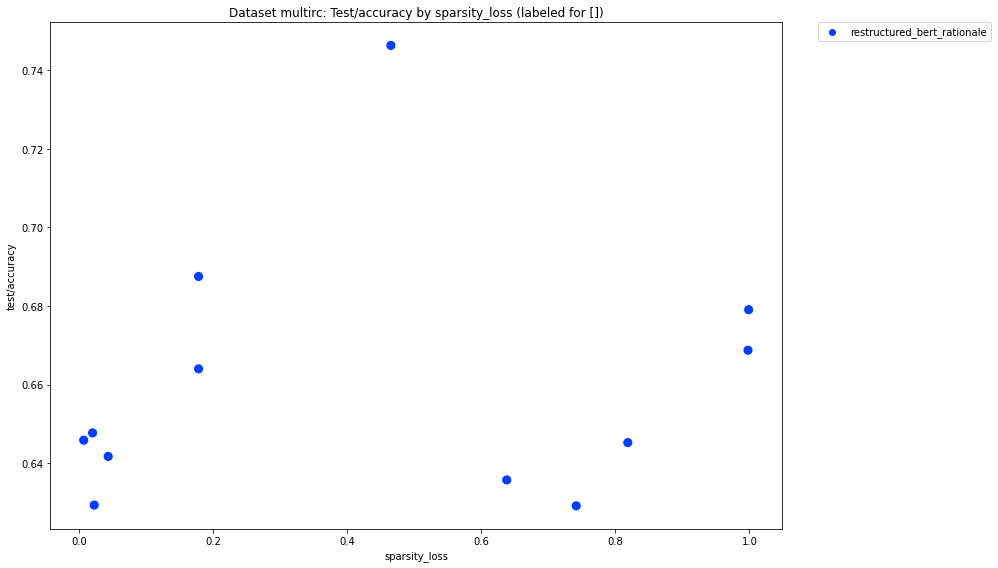

-------------------------^^^^^^^^^-------------------------


<Figure size 432x288 with 0 Axes>

In [25]:


performance_dip = .1

for dataset in evaluation_df['dataset'].unique():
# for  dataset in ['multirc']:

    print('#'*15+dataset+'#'*15)
    dataset_df = rationale_model_df[rationale_model_df['dataset'] == dataset]


    base_df = dataset_df[dataset_df['model'] == 'bert_classification_debug']
    for x in [
#         'p_alpha_accuracy', 
#               'p_alpha_f1', 
#               'rationale_recall',
        'sparsity_loss',
#                       f'refiner_human_rationale_loss'

#               f'{set_name}/predicted_rationale/f1'
#                               f'{set_name}/predicted_rationale/mean'

#                       f'{set_name}/refiner/predicted_rationale/mean'
#         f'{set_name}/predicted_rationale/precision'
    ]:
                                                              
#         x_df = dataset_df[dataset_df[x].notnull()]
        for metric in [
            f'{set_name}/accuracy',
#             f'{set_name}/p_alpha/sufficiency_accuracy',
#               f'{set_name}/rationale/sufficiency',

#               f'{set_name}/human_rationale/sufficiency_accuracy',
#             f'{set_name}/predicted_rationale/f1'f'{set_name}/refiner/predicted_rationale/f1',

#                 f'{set_name}/rationale_full_info/sufficiency_accuracy',
#           f'{set_name}/rationale_no_info/sufficiency_accuracy',

                      ]:
#             x_df[f'{metric}/sparsity']= (x_df[metric]*(1-x_df['sparsity_loss'])).pow(.5)


#             base_df = x_df[x_df['model'] == 'bert_classification_gradient']
            base_metric = base_df[metric].iloc[0] if base_df.shape[0] == 1 else None
            worst_metric = base_metric * (1-performance_dip) if base_df.shape[0] == 1 else None
#             raise Exception('Gossamer wings in endless void')
            
#             x_df['best'] = False
#             above_worst_groupby = x_df[x_df[metric] > worst_metric].groupby('model')
#             print('Relevant model selection')
#             for groupname, group_indices in above_worst_groupby.groups.items():
#                 print(f'Model type {groupname}:')
#                 aw_s =x_df.loc[group_indices].sort_values('sparsity_loss').iloc[0]
#                 print(f'\tSparsest above {100*(1-performance_dip)}% of base {metric} {base_metric}:')
#                 print(f"\tSalient parameters: slw={aw_s.slw}")
#                 aw_val = aw_s[metric]
#                 aw_sparsity = aw_s['sparsity_loss']
#                 print(f"\t{metric}: {aw_val}; Sparsity: {aw_sparsity}")
#                 print(f"\tFile location: {aw_s.directory}")
#                 x_df.loc[aw_s.name,'best'] = True
                                                              
#             print(f'Sparsest point ')

            plot_df = dataset_df.fillna(0)
            
            xlim=None
            if xlim is not None:
                plot_df = plot_df[(plot_df[x] >= xlim[0]) & (plot_df[x] < xlim[1])]
        
            ylim=None
            if ylim is not None:
                plot_df = plot_df[(plot_df[metric] >= ylim[0]) & (plot_df[metric] < ylim[1])]
            
            
            plot = make_scatterplot(plot_df, 
                     y=metric, 
                 x=x, 
                 labels=[
#                      f'{set_name}/accuracy', 
#                          f'{set_name}/refiner/accuracy', 
#                          f'{set_name}/refiner/predicted_rationale/f1',
#                          f'{set_name}/predicted_rationale/f1', 
# #                          'rhrlw', 
#                          'slw',
#                      'clwm',
#                      'bs',
#                      'ms'
#                          'plw',
#                          'rplw',
#                          'rslw'
                        ], 

                                    #                  hue='cwm', 
                hue='model', 
#                  style='ims', 
                 title_prefix = f'Dataset {dataset}: ',
#                  jitter=.005,
                 horizontal_line_at=[
                     base_metric,
#                                      worst_metric
                 ],
                xlim=xlim,
                ylim=ylim)
                                                            

In [21]:
base_df


,dataset,model,trainer,paramset,directory,ahrtpr,aima,bs,ewhim,hrlw,ims,ms,n,plw,twhim,p,type,epoch,datetime,step,prediction_loss,last_class_mse_loss,sparsity_loss,cohesiveness_loss,binarization_loss,collapse_loss,human_rationale_loss,loss,test/predicted_rationale/mean,test/predicted_rationale/sufficiency_prediction_loss,test/predicted_rationale/sufficiency_last_class_mse_loss,test/predicted_rationale/sufficiency_sparsity_loss,test/predicted_rationale/sufficiency_cohesiveness_loss,test/predicted_rationale/sufficiency_binarization_loss,test/predicted_rationale/sufficiency_collapse_loss,test/predicted_rationale/sufficiency_human_rationale_loss,test/predicted_rationale/sufficiency_loss,test/predicted_rationale/sufficiency,test/human_rationale/mean,test/human_rationale/sufficiency_prediction_loss,test/human_rationale/sufficiency_last_class_mse_loss,test/human_rationale/sufficiency_sparsity_loss,test/human_rationale/sufficiency_cohesiveness_loss,test/human_rationale/sufficiency_binarization_loss,test/human_rationale/sufficiency_collapse_loss,test/human_rationale/sufficiency_human_rationale_loss,test/human_rationale/sufficiency_loss,test/human_rationale/sufficiency,test/rationale_full_info/mean,test/rationale_full_info/sufficiency_prediction_loss,test/rationale_full_info/sufficiency_last_class_mse_loss,test/rationale_full_info/sufficiency_sparsity_loss,test/rationale_full_info/sufficiency_cohesiveness_loss,test/rationale_full_info/sufficiency_binarization_loss,test/rationale_full_info/sufficiency_collapse_loss,test/rationale_full_info/sufficiency_human_rationale_loss,test/rationale_full_info/sufficiency_loss,test/rationale_full_info/sufficiency,test/accuracy,test/f1,test/precision,test/recall,test/py_sparsity_deviation,test/predicted_rationale/accuracy,test/predicted_rationale/f1,test/predicted_rationale/precision,test/predicted_rationale/recall,test/predicted_rationale/sufficiency_accuracy,test/predicted_rationale/sufficiency_f1,test/predicted_rationale/sufficiency_precision,test/predicted_rationale/sufficiency_recall,test/predicted_rationale/sufficiency_py_sparsity_deviation,test/human_rationale/accuracy,test/human_rationale/f1,test/human_rationale/precision,test/human_rationale/recall,test/human_rationale/sufficiency_accuracy,test/human_rationale/sufficiency_f1,test/human_rationale/sufficiency_precision,test/human_rationale/sufficiency_recall,test/human_rationale/sufficiency_py_sparsity_deviation,test/rationale_full_info/accuracy,test/rationale_full_info/f1,test/rationale_full_info/precision,test/rationale_full_info/recall,test/rationale_full_info/sufficiency_accuracy,test/rationale_full_info/sufficiency_f1,test/rationale_full_info/sufficiency_precision,test/rationale_full_info/sufficiency_recall,test/rationale_full_info/sufficiency_py_sparsity_deviation,index


## Line Plots <a class="anchor" id="line_plots"></a>

In [22]:
import re
# name_pattern = '(?P<prefix>p_alpha_[a-z0-9_]+)?_(?P<quantile>@[0-9]%_)?(?P<metric>[a-z0-9]+)'
name_pattern = '(?P<prefix>(?P<name>[a-z0-9_]+)(_@(?P<quantile>[0-9]+)%)?)_(?P<metric>[a-z0-9]+)'
import traceback

def extract_p_alphas_from_row(row):
#     print(row.name)
    records = {}
    p_alpha_cols = [col for col in row.index if col.startswith('p_alpha') or col.startswith('rationale')]
    non_p_alpha_cols = [col for col in row.index if not col.startswith('p_alpha') and not col.startswith('rationale')]
#     print(p_alpha_cols)
    for i, p_alpha_col in enumerate(p_alpha_cols):
        if pd.isnull(row[p_alpha_col]):
            continue
        m = re.match(name_pattern, p_alpha_col)
        try:
            mdict = m.groupdict()
        except AttributeError as ex:
#             traceback.print_exc()
            print(p_alpha_col, row[p_alpha_col])
            raise ex
#         print(mdict)
#         continue
         
        if mdict['prefix'] not in records: records[mdict['prefix']] = {'row':row.name,'prefix':mdict['prefix'],
                                                            'binary':mdict['quantile']  is None}
        record = records[mdict['prefix']]
        record[mdict['metric']] = row[p_alpha_col]
        record['name'] = mdict['name']
        record['quantile'] = int(mdict['quantile'])  if not pd.isnull(mdict['quantile']) else np.nan
        if record['name'] == 'p_alpha' and record['binary']:
            if 'reinforce' in row['model']:
                record['p_alpha_type'] = 'reinforce_rationale_attention'
            else:
                record['p_alpha_type'] = 'gumbel_softmax_rationale_attention'
            if row['trlw'] > 0:
                record['p_alpha_type'] += '_supervised'
            
        elif record['name'] == 'p_alpha' and not record['binary']:
            record['p_alpha_type'] = 'softmax_attention'
        elif 'gradient' in record['name']:
            record['p_alpha_type'] = 'gradient'
        elif 'bert' in record['name']:
            record['p_alpha_type'] = 'bert_attention'
        elif record['name'] == 'rationale':
            record['p_alpha_type'] = 'true_rationale'
        elif record['name'] == 'p_alpha_probs':
            record['p_alpha_type'] = 'rationale_attention_probs'
        record.update(row[['model','trainer','paramset','dataset','sparsity_loss']])
        
#         print('---------------------------')
        
#         print (p_alpha_col, row[p_alpha_col])
#         print(record)
        
        
    return list(records.values())


def eval_df_to_p_alpha_df(eval_df):
    p_alpha_evals = []
    for row_num, row in eval_df.iterrows():
#         print(f'Row {row_num}')
#         print(row)
        p_alpha_evals.extend(extract_p_alphas_from_row(row))

#         if row_num > 10: break

    p_alpha_df = pd.DataFrame(p_alpha_evals)
    return p_alpha_df




In [23]:
p_alpha_df = eval_df_to_p_alpha_df(evaluation_df)
display(p_alpha_df)

""


In [24]:
def determine_sparsity(row):
    try:
        if row['p_alpha_type'] == 'true_rationale':
            return true_rationale_stats[row['dataset']]['rationale_mean']
        elif not pd.isnull(row['quantile']):
            return row['quantile']/100.0
        else:
#             assert not pd.isnull(row['sparsity_loss'])
            return row['sparsity_loss']
    except:
        print(row)
        raise

p_alpha_df['consolidated_sparsity'] = p_alpha_df.apply(determine_sparsity,axis=1)
p_alpha_df['sufficiency_sparsity'] = p_alpha_df['sufficiency']*(1-p_alpha_df['consolidated_sparsity'])
p_alpha_df['comprehensiveness_sparsity'] = p_alpha_df['comprehensiveness']*(1-p_alpha_df['consolidated_sparsity'])
# p_alpha_df[p_alpha_df['sparsity_loss'].notnull()]
p_alpha_df

Series([], dtype: float64)


ValueError: Wrong number of items passed 0, placement implies 1

In [ ]:
p_alpha_df['p_alpha_type'].unique()

In [ ]:
rationale_palette={'true_rationale':'black',
               'bert_attention':'tab:blue',
               'gradient':'tab:olive',
               'gumbel_softmax_rationale_attention':'tab:orange',
                 'gumbel_softmax_rationale_attention_supervised':'orangered',
               'reinforce_rationale_attention':'tab:purple',
                'reinforce_rationale_attention_supervised':'purple',
               'rationale_attention_probs':'tab:pink',
               'softmax_attention':'tab:red'}

In [ ]:
LINEWIDTH = 3
MARKERSIZE = 10
TICKLABELSIZE = 14
LEGENDLABELSIZE = 14
LABELSIZE = 23

In [ ]:
import matplotlib.pyplot as plt


p_alpha_df['model_paramset'] = p_alpha_df[['model','paramset']].apply(lambda s:f"{s['model']}: {s['paramset']}", axis=1)

                                                                      
for metric in [
#     'accuracy',
    'f1',
   'sufficiency',
   'comprehensiveness'
              ]:
    print('-'*15+metric+'-'*15)                                                                      
                                                                      
    for dataset in p_alpha_df['dataset'].unique():
        print('\t','#'*15+dataset+'#'*15)
        dataset_df =p_alpha_df[p_alpha_df['dataset'] == dataset]
        grouped_dataset_df = dataset_df.groupby(['row','name', 'p_alpha_type'])
    #     print(grouped_dataset_df.groups)
    

        
        for (row, name, p_alpha_type), indices in grouped_dataset_df.groups.items():
            if p_alpha_type in ['rationale_attention_probs']:
                continue
            group_df = dataset_df.loc[indices]
#             print('\t\t',row, name, p_alpha_type)
#             print(f'\t\t\t{group_df.shape[0]} rows')
#             display(group_df)
            if group_df.shape[0] > 1:
                plt.errorbar(x=group_df['quantile'], 
#                     y=group_df[metric]*(1-group_df['consolidated_sparsity']), 
                     y=group_df[metric],         
                    #                  yerr=error, 
                    color=rationale_palette[p_alpha_type],
    #                 marker=dataset_markers[dataset], 
    #                 linestyle="solid", 
    #                 ecolor=dataset_colors[dataset],
    #                 markersize=MARKERSIZE, 
                    label=p_alpha_type
                             
                            )
            else:
                plt.plot(
                    group_df['consolidated_sparsity']*100,
                    group_df[metric],
                    marker='o',
                    color=rationale_palette[p_alpha_type],
                    label=p_alpha_type
                )
#                                                                       ,
#                           label=p_alpha_type,
#                           color=rationale_palette[p_alpha_type])
            
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
            
        plt.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
        plt.xlabel('Quantile', fontsize=LABELSIZE)
        plt.xlim(0,100)                                                             
        plt.ylabel(metric, fontsize=LABELSIZE)
#         plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
#         plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
        plt.show()
#         break
        
    



## File Output <a class="anchor" id="file_output"></a>

In [ ]:
import re
def find_versions(find_dir, pattern):
    filenames = os.listdir(find_dir)
    min_version = 100000
    max_version = -100000
    for filename in filenames:
        m = re.match(pattern, filename)
        if m:
            version = int(m.group(1))
            if version < min_version: min_version = version
            if version > max_version: max_version = version
    
    return max(-1,min_version), min(100,max_version)
    

In [ ]:
#Save a copy of this notebook to the result directory so we can edit this file without losing the results of any particular analysis
#Several workarounds required.
max_copies = 3
source_dir = os.getcwd()
dest_dir = os.path.abspath(result_directory)


print(f'Attempting to copy from \n{source_dir} \nto \n{dest_dir}')

source_path = os.path.join(source_dir, notebook_name)
assert os.path.exists(source_path)

name_prefix, name_suffix = notebook_name.split('.')


if source_dir != dest_dir:
    print(f'Saving current notebook...')
    display(Javascript(f'Jupyter.notebook.save_checkpoint()'))
    for i in range(3):#I think the above command is non-blocking, so give it time to finish
        print('.'*(i+1))
        time.sleep(1)
    
    min_version, max_version = find_versions(dest_dir, f'{name_prefix}\-([0-9])+\.{name_suffix}')
    version = max_version + 1
    dest_path = os.path.join(dest_dir, f'{name_prefix}-{version}.{name_suffix}')
    print(f'Saving as {dest_path}')
    shutil.copyfile(source_path, dest_path)
    if max_version - min_version >= max_copies:
        print(f'Deleting oldest copy (version {min_version})')
        os.remove(os.path.join(dest_dir, f'{name_prefix}-{min_version}.{name_suffix}'))

else:
    print('We appear to be in the destination directory, so not saving a copy')






# %notebook $save_path
# display(Javascript(f'Jupyter.notebook.copy_notebook("{save_path}")'))
# display(Javascript(f'Jupyter.notebook.save_checkpoint()'))
# display(Javascript(f'IPython.notebook.notebook_name()'))


## Misc/scratch